# Case Study: MyoPS - myocardial pathology segmentation

In [ ]:
#hide
#nbdev_torch16_test all

In [ ]:
#hide
#skip
! [[ -e /content ]] && git clone https://github.com/chfc-cmi/misas && cd misas && pip install .
import os
if os.path.isdir('/content/misas'):
    os.chdir('/content/misas')

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Aim: Apply to MyoPS data

This is a more complex application of `misas` to a multi-channel input model with multiple output classes. It uses data from the Myocardial pathology segmentation combining multi-sequence CMR challenge ([MyoPS 2020](http://www.sdspeople.fudan.edu.cn/zhuangxiahai/0/MyoPS20/)).

General results are published in ["Myocardial Pathology Segmentation Combining Multi-Sequence Cardiac Magnetic Resonance Images." First Challenge, MyoPS 2020, Held in Conjunction with MICCAI 2020, Lima, Peru, October 4, 2020, Proceedings](https://doi.org/10.1007/978-3-030-65651-5) and the specific model is described in 
> [Ankenbrand M.J., Lohr D., Schreiber L.M. (2020) "Exploring Ensemble Applications for Multi-sequence Myocardial Pathology Segmentation." In: Zhuang X., Li L. (eds) Myocardial Pathology Segmentation Combining Multi-Sequence Cardiac Magnetic Resonance Images. MyoPS 2020. Lecture Notes in Computer Science, vol 12554. Springer, Cham.](https://doi.org/10.1007/978-3-030-65651-5_6)

supplemented by https://github.com/chfc-cmi/miccai2020-myops

> Warning: As this model uses a specific development version of `fastai v2` and data from the challenge can not be freely shared it is much harder to reproduce the results from this notebook. You need to request the data from [the challenge website](http://www.sdspeople.fudan.edu.cn/zhuangxiahai/0/MyoPS20/data1.html), download the model from zenodo
[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.3985837.svg)](https://doi.org/10.5281/zenodo.3985837)
and install the specific versions of packages listed at the bottom of the page (other versions might work too but are untested).

## Prepare Model for `misas`

In [ ]:
from fastai.vision.all import *
from fastai.vision.models import resnet34

In [ ]:
class AddMaskCodeMapping(Transform):
    "Add mapping of pixel value to class for a `TensorMask`"
    def __init__(self, mapping, codes=None):
        #print("init")
        self.mapping = mapping
        self.codes = codes
        if codes is not None: self.vocab,self.c = codes,len(codes)

    def encodes(self, o:PILMask):
        #print("encodes")
        mo = ToTensor()(o)
        mo = mo.to(dtype=torch.long)
        mo = self.mapping.index_select(0,mo.flatten()).reshape(*mo.shape)
        mo = PILMask.create(mo.to(dtype=torch.uint8))
        return mo
    
    def decodes(self, o:TensorMask):
        # decoding of inputs works out of the box, but get_preds are not properly decoded
        if len(o.shape) > 2:
            o = o.argmax(dim=0)
        if self.codes is not None: o._meta = {'codes': self.codes}
        return o

In [ ]:
def MappedMaskBlock(mapping,codes=None):
    "A `TransformBlock` for segmentation masks, with mapping of pixel values to classes, potentially with `codes`"
    return TransformBlock(type_tfms=PILMask.create, item_tfms=AddMaskCodeMapping(mapping=mapping,codes=codes), batch_tfms=IntToFloatTensor)

In [ ]:
def getMappedMaskBlock(predefined_mapping_name):
    predefined_mappings = {
        'full': ([0,1,2,3,4,5],['bg','lv','my','rv','ed','sc']),
        'edOnly': ([0,0,0,0,1,0],['bg','ed']),
        'edScCombined': ([0,0,0,0,1,1],['bg','edSc']),
        'scOnly': ([0,0,0,0,0,1],['bg','sc']),
        'edScOnly': ([0,0,0,0,1,2],['bg','ed','sc']),
    }
    mapping,codes = predefined_mappings[predefined_mapping_name]
    return MappedMaskBlock(mapping = torch.LongTensor(mapping), codes=codes)

In [ ]:
def get_train_files(path):
    items = get_image_files(path)
    items = L([x for x in items if x.name.startswith("1")])
    return items

In [ ]:
def getMyopsDls(mapping_name="full", images="images", path="/storage/biomeds/data/myops/"):
    mmb = getMappedMaskBlock(mapping_name)
    myopsData = DataBlock(blocks=(ImageBlock, mmb),#['bg','lv','my','rv','ed','sc'])),
        get_items=get_train_files,
        splitter=FuncSplitter(lambda o: False),
        get_y=lambda o: str(o).replace(images,"masks"),
        item_tfms=CropPad(256),
        batch_tfms=aug_transforms(max_rotate=90,pad_mode="zeros"))
    dls = myopsData.dataloaders(f'{path}/{images}',num_workers=4,batch_size=12)
    dls[1].bs = 12
    return dls

In [ ]:
def multi_dice(input:Tensor, targs:Tensor, class_id=0, inverse=False)->Tensor:
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    # replace all with class_id with 1 all else with 0 to have binary case
    output = (input == class_id).float()
    # same for targs
    targs = (targs.view(n,-1) == class_id).float()
    if inverse:
        output = 1 - output
        targs = 1 - targs
    intersect = (output * targs).sum(dim=1).float()
    union = (output+targs).sum(dim=1).float()
    res = 2. * intersect / union
    res[torch.isnan(res)] = 1
    return res.mean()

def diceFG(input, targs): return multi_dice(input,targs,class_id=1)
def diceLV(input, targs): return multi_dice(input,targs,class_id=1)
def diceMY(input, targs): return multi_dice(input,targs,class_id=2)
def diceRV(input, targs): return multi_dice(input,targs,class_id=3)
def diceEd(input, targs): return multi_dice(input,targs,class_id=4)
def diceSc(input, targs): return multi_dice(input,targs,class_id=5)
dices = [diceLV,diceMY,diceRV,diceEd,diceSc]

In [ ]:
 getMyopsDls("full", "images")

/home/csa84mikl/miniconda3/lib/python3.9/site-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
learn = unet_learner(
        getMyopsDls("full", "images"),
        resnet34
    )

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


In [ ]:
#from fastai.vision.all import Image as F1Image
#from fastai.vision.all import ImageSegment as F1ImageSegment

## Prepare Dataset for `misas`

Data is available as png images and masks which is just fine for `misas`

In [ ]:
#from fastai.vision import open_image, open_mask
from misas.core import default_cmap
from PIL import ImageOps

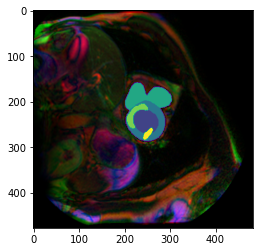

In [ ]:
#img = lambda: open_image("example/myops/images/101-orig-4.png")
#trueMask = lambda: open_mask("example/myops/masks/101-orig-4.png")
#img().show()
#trueMask().show()
img = lambda: Image.open("/storage/biomeds/data/myops/images/101-orig-4.png").convert("RGB")
trueMask = lambda: Image.open("/storage/biomeds/data/myops/masks/101-orig-4.png").convert("I")
plt.imshow(img())
plt.imshow(np.array(trueMask()), cmap=default_cmap)



In [ ]:
class Fastai2_model:
    def __init__(self, learner):
        self.trainedModel = learner
        
    def prepareSize(self, item): #, asPIL=False):     
        to_cut_w=((item.size[0]-256)/2)
        to_cut_h=((item.size[1]-256)/2)
        image = ImageOps.crop(item, (np.floor(to_cut_w), np.floor(to_cut_h), np.ceil(to_cut_w), np.ceil(to_cut_h)))
        return image
        
    def predict(self, image):
        image = self.prepareSize(image)#, #asPIL=True)
        image = PILImage.create(np.array(image))
        with self.trainedModel.no_bar():
            mask = self.trainedModel.predict(image)[0]#(pilimg) #mask,probs,rest 
        output = Image.fromarray(np.array(mask).astype(np.uint8))
        return output #mask, probs

# model = Fastai1_model('example/b0','b0_transversal_5_5') # if it were local
model = Fastai2_model(learn.load("../../Downloads/multi_ce_full"))

## How does the trained model perform on this (training) example?

#Time to apply the model to the example image and see how it works (we need to call `prepareSize` manually here):

In [ ]:
#hide
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from misas.core import *
from misas.core import default_cmap

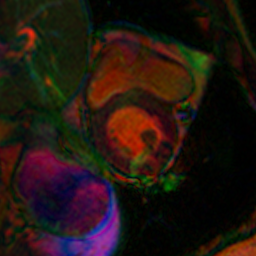

In [ ]:
model.prepareSize(img())

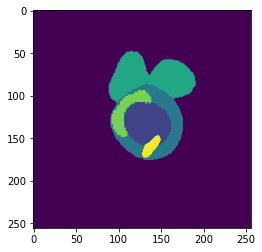

In [ ]:
plt.imshow(np.array(model.prepareSize(trueMask())))

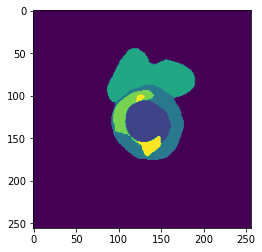

In [ ]:
mask = model.predict(img())
plt.imshow(np.array(mask))

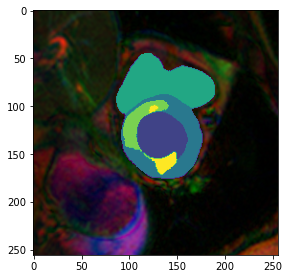

In [ ]:
fig,ax = plt.subplots(figsize=(4.5,4.5))
plt.imshow(model.prepareSize(img()))
plt.imshow(mask, cmap=default_cmap)

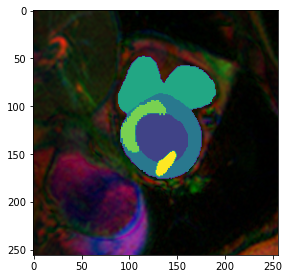

In [ ]:
fig,ax = plt.subplots(figsize=(4.5,4.5))
plt.imshow(model.prepareSize(img()))
plt.imshow(np.array(model.prepareSize((trueMask()))), cmap=default_cmap)

## Robustness to basic transformations

In [ ]:
#img = lambda: open_image(files[0]).resize(256)
#trueMask = lambda: open_mask(files[0].replace("image","mask"))

### Sensitivity to orientation

Changes in orientation are very common. Not because it is common to acquire images in different orientation but because the way data is stored in different file formats like nifti and dicom differs. So it is interesting to see how the model works in all possible orientations (including flips).

  0%|          | 0/8 [00:00<?, ?it/s]

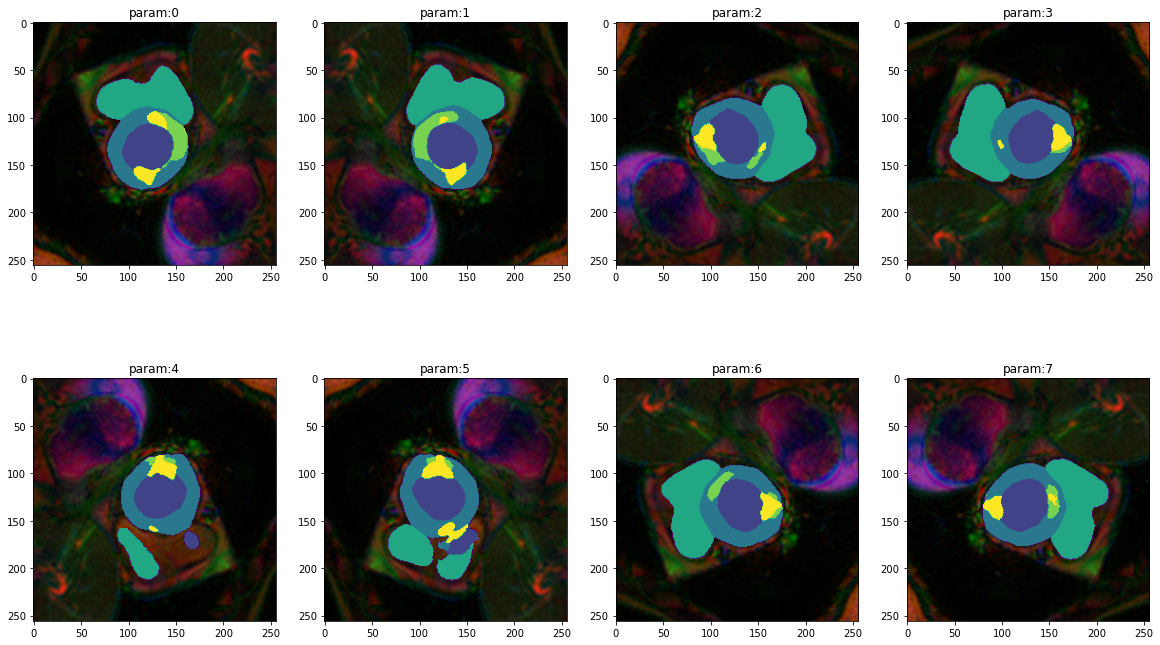

In [ ]:
dihed = get_dihedral_series(img(),model)
plot_series(dihed, nrow=2, figsize=(20,12))

In [ ]:
#plt.imshow(np.array(dihed [0][2].convert ("I")))
#dihed[0][1]

### Sensitivity to rotation

Let's get an impression of how quickly segmentation performance decreases with deviations in rotation.

  0%|          | 0/12 [00:00<?, ?it/s]

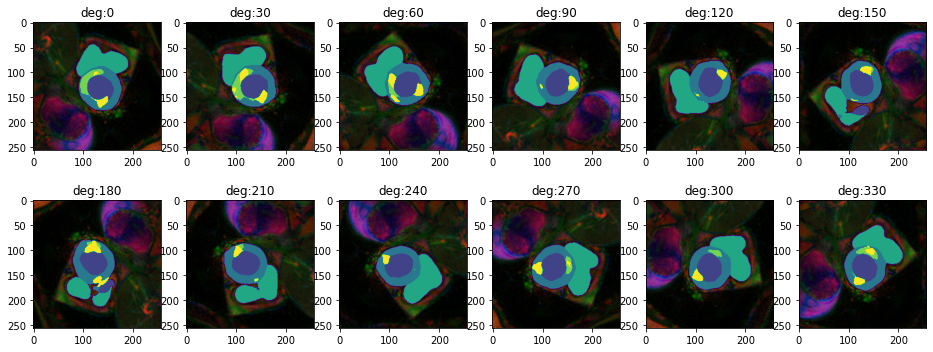

In [ ]:
plot_series(get_rotation_series(img(),model, step=30), nrow=2, param_name="deg")

  0%|          | 0/6 [00:00<?, ?it/s]

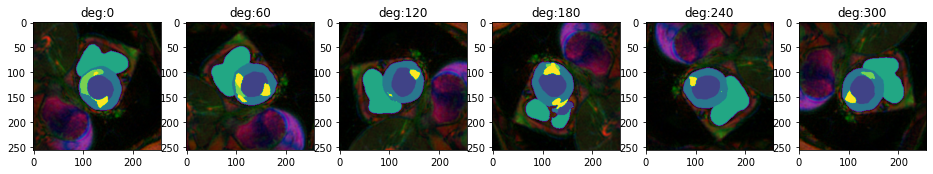

In [ ]:
plot_series(get_rotation_series(img(),model, step=60), nrow=1, param_name="deg")

In [ ]:
results = eval_rotation_series(img(),trueMask(),model,start=-180,end=180,components=["bg","LV","MY","RV","edema","scar"])

  0%|          | 0/72 [00:00<?, ?it/s]

In [ ]:
import altair as alt

In [ ]:
(alt
 .Chart(results.melt(id_vars=['deg'],value_vars=['LV','MY','RV','edema','scar']))
 .mark_line()
 .encode(
     x="deg",
     y="value",
     color="variable",
     tooltip="value"
 )
 .properties(width=700,height=300)
 .interactive()
)

alt.Chart(...)

So the range where prediction performance remains stable is quite large for most classes. However the rarer pathology classes scar and particularly edema react 
much more sensitively to rotation.

In [ ]:
gif_series(
    get_rotation_series(img(),model, start=1, end=360,step=10),
    "example/myops/rotation.gif",
    param_name="deg",
    duration=400
)

  0%|          | 0/36 [00:00<?, ?it/s]

![segmentation sensitivity to rotation](example/myops/rotation.gif)

### Sensitivity to cropping

Another variation that might occur in real life is a difference in field of view. This can happen due to different settings when acquiring the images or due to pre-processing steps in an analysis pipeline.

  0%|          | 0/15 [00:00<?, ?it/s]

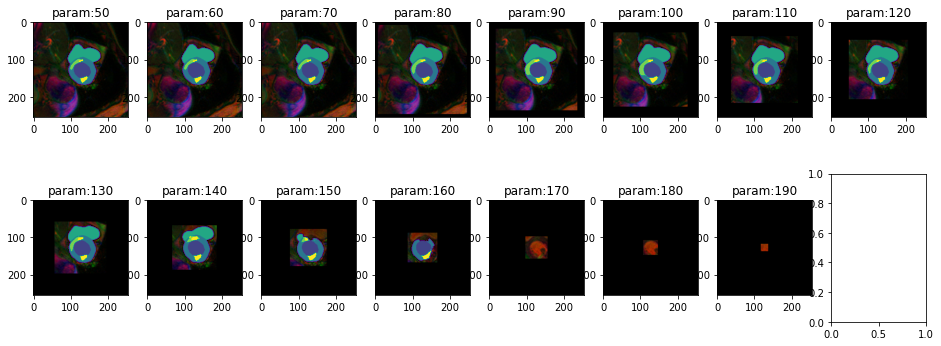

In [ ]:
plot_series(get_crop_series(img(),model, start = 50, end = 230, step = 10, finalSize=400), nrow=2, vmax=5) 

  0%|          | 0/6 [00:00<?, ?it/s]

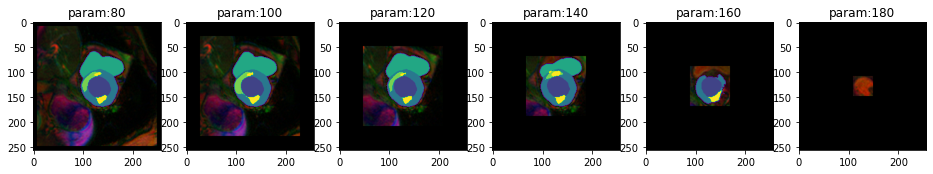

In [ ]:
plot_series(get_crop_series(img(),model, start = 80, end = 230, step = 20, finalSize=400), nrow=1, vmax=5)

In [ ]:
gif_series(
    get_crop_series(img(),model, start=50, end=250,step=10),
    "example/myops/crop.gif",
    param_name="pixels",
    duration=400,
    vmax=5
)

  0%|          | 0/19 [00:00<?, ?it/s]

![segmentation sensitivity to rotation - myops](example/myops/crop.gif)

It seems to be okay to crop the image to some extend. But performance degrades even before we start to crop part of the heart.

In [ ]:
results = eval_crop_series(img(),trueMask(),model,start = 50, end=256, finalSize=400, components=["bg","LV","MY","RV","edema","scar"])

  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
(alt
 .Chart(results.melt(id_vars=['pixels'],value_vars=['LV','MY','RV','edema','scar']))
 .mark_line()
 .encode(
     x="pixels",
     y="value",
     color="variable",
     tooltip="value"
 )
 .properties(width=700,height=300)
 .interactive()
)

alt.Chart(...)

### Sensitivity to brightness

  0%|          | 0/11 [00:00<?, ?it/s]

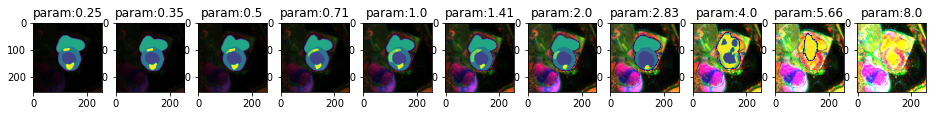

In [ ]:
plot_series(get_brightness_series(img(),model), nrow=1) #end = 0.99, step = 0.18

In [ ]:
results = eval_bright_series(img(),trueMask(),model, components=["bg","LV","MY","RV","edema","scar"])

  0%|          | 0/18 [00:00<?, ?it/s]

In [ ]:
(alt
 .Chart(results.melt(id_vars=['brightness'],value_vars=['LV','MY','RV','edema','scar']))
 .mark_line()
 .encode(
     x="brightness",
     y="value",
     color="variable",
     tooltip="value"
 )
 .properties(width=700,height=300)
 .interactive()
)

alt.Chart(...)

### Sensitivity to contrast

  0%|          | 0/11 [00:00<?, ?it/s]

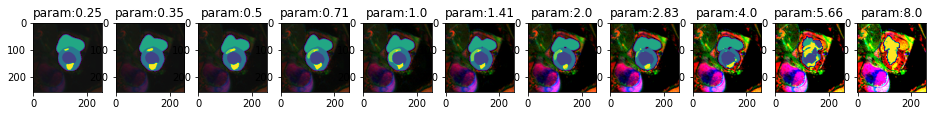

In [ ]:
plot_series(get_contrast_series(img(),model), nrow = 1, vmax=5) #start=0.1, end=3, step=0.5

In [ ]:
results = eval_contrast_series(img(),trueMask(),model, components=["bg","LV","MY","RV","edema","scar"]) #end = 2.5, step = 0.3

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
(alt
 .Chart(results.melt(id_vars=['contrast'],value_vars=['LV','MY','RV','edema','scar']))
 .mark_line()
 .encode(
     x="contrast",
     y="value",
     color="variable",
     tooltip="value"
 )
 .properties(width=700,height=300)
 .interactive()
)

alt.Chart(...)

### Sensitivity to zoom

  0%|          | 0/10 [00:00<?, ?it/s]

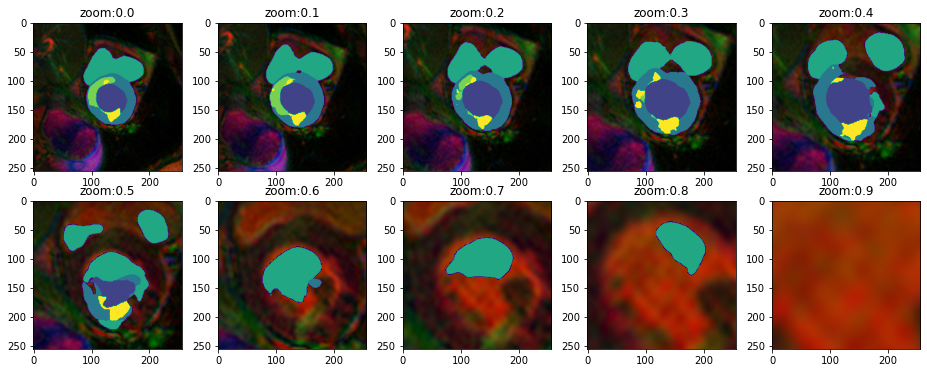

In [ ]:
plot_series(get_zoom_series(img(),model), param_name="zoom", nrow=2, vmax=5) #start=160,end=750,step=60, finalSize=480)

  0%|          | 0/10 [00:00<?, ?it/s]

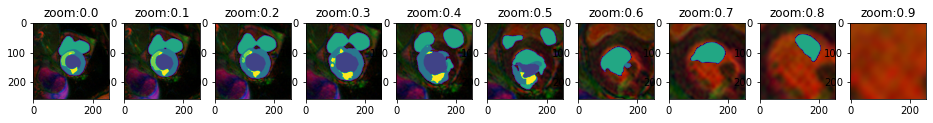

In [ ]:
plot_series(get_zoom_series(img(),model), param_name="zoom", nrow=1, vmax=5)#,start=160,end=770,step=120, finalSize=480)

In [ ]:
results = eval_zoom_series(img(),trueMask(),model,components=["bg","LV","MY","RV","edema","scar"]) #,start=160,end=900,step=20,finalSize=480

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
(alt
 .Chart(results.melt(id_vars=['scale'],value_vars=['LV','MY','RV','edema','scar']))
 .mark_line()
 .encode(
     x="scale",
     y="value",
     color="variable",
     tooltip="value"
 )
 .properties(width=700,height=300)
 .interactive()
)

alt.Chart(...)

In [ ]:
gif_series(
    get_zoom_series(img(),model) , #start=50, end=900,step=50
    "example/myops/zoom.gif",
    param_name="scale",
    duration=400,
    vmax=5
)

![segmentation sensitivity to zoom](example/myops/zoom.gif)

**IDEA: Channel imbalance transformation** 
For multi-channel images it might be useful to consider transformations that work differently on different channels.

## Robustness to MR artifacts

**It would be nice to analyze the effect of MR artifacts. However, we are dealing with multi-channel images here. Each channel is a separate MR image. So it is not obvious how to deal with this.**

## Package Versions

```
# packages in environment at /opt/conda/envs/misas:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       1_gnu    conda-forge
absl-py                   0.11.0                   pypi_0    pypi
altair                    4.1.0                    pypi_0    pypi
argon2-cffi               20.1.0                   pypi_0    pypi
astunparse                1.6.3                    pypi_0    pypi
async-generator           1.10                     pypi_0    pypi
attrs                     20.3.0                   pypi_0    pypi
backcall                  0.2.0                    pypi_0    pypi
beautifulsoup4            4.9.3                    pypi_0    pypi
bleach                    3.2.1                    pypi_0    pypi
blis                      0.7.4                    pypi_0    pypi
bottleneck                1.3.2                    pypi_0    pypi
ca-certificates           2020.12.5            ha878542_0    conda-forge
cachetools                4.2.0                    pypi_0    pypi
catalogue                 1.0.0                    pypi_0    pypi
certifi                   2020.12.5        py36h5fab9bb_0    conda-forge
cffi                      1.14.4                   pypi_0    pypi
chardet                   4.0.0                    pypi_0    pypi
click                     7.1.2                    pypi_0    pypi
contextvars               2.4                      pypi_0    pypi
cycler                    0.10.0                   pypi_0    pypi
cymem                     2.0.5                    pypi_0    pypi
dataclasses               0.8                      pypi_0    pypi
decorator                 4.4.2                    pypi_0    pypi
defusedxml                0.6.0                    pypi_0    pypi
entrypoints               0.3                      pypi_0    pypi
fastai                    1.0.61                   pypi_0    pypi
fastai2                   0.0.30                   pypi_0    pypi
fastcore                  1.0.0                    pypi_0    pypi
fastinference             0.0.35                   pypi_0    pypi
fastprogress              1.0.0                    pypi_0    pypi
fastscript                1.0.0                    pypi_0    pypi
flatbuffers               1.12                     pypi_0    pypi
future                    0.18.2                   pypi_0    pypi
gast                      0.3.3                    pypi_0    pypi
gif                       2.0.0                    pypi_0    pypi
google-auth               1.24.0                   pypi_0    pypi
google-auth-oauthlib      0.4.2                    pypi_0    pypi
google-pasta              0.2.0                    pypi_0    pypi
grpcio                    1.32.0                   pypi_0    pypi
h5py                      2.10.0                   pypi_0    pypi
humanize                  3.2.0                    pypi_0    pypi
idna                      2.10                     pypi_0    pypi
imageio                   2.9.0                    pypi_0    pypi
immutables                0.14                     pypi_0    pypi
importlib-metadata        3.3.0                    pypi_0    pypi
ipykernel                 5.4.2                    pypi_0    pypi
ipython                   7.16.1                   pypi_0    pypi
ipython-genutils          0.2.0                    pypi_0    pypi
ipywidgets                7.6.2                    pypi_0    pypi
jedi                      0.18.0                   pypi_0    pypi
jinja2                    2.11.2                   pypi_0    pypi
joblib                    1.0.0                    pypi_0    pypi
jsonschema                3.2.0                    pypi_0    pypi
jupyter                   1.0.0                    pypi_0    pypi
jupyter-client            6.1.7                    pypi_0    pypi
jupyter-console           6.2.0                    pypi_0    pypi
jupyter-core              4.7.0                    pypi_0    pypi
jupyterlab-pygments       0.1.2                    pypi_0    pypi
jupyterlab-widgets        1.0.0                    pypi_0    pypi
keras-preprocessing       1.1.2                    pypi_0    pypi
kiwisolver                1.3.1                    pypi_0    pypi
kornia                    0.2.2                    pypi_0    pypi
libgcc-ng                 9.3.0               h5dbcf3e_17    conda-forge
libgomp                   9.3.0               h5dbcf3e_17    conda-forge
markdown                  3.3.3                    pypi_0    pypi
markupsafe                1.1.1                    pypi_0    pypi
matplotlib                3.3.3                    pypi_0    pypi
misas                     0.0.3                     dev_0    <develop>
mistune                   0.8.4                    pypi_0    pypi
murmurhash                1.0.5                    pypi_0    pypi
nbclient                  0.5.1                    pypi_0    pypi
nbconvert                 6.0.7                    pypi_0    pypi
nbdev                     1.0.10                   pypi_0    pypi
nbformat                  5.0.8                    pypi_0    pypi
ncurses                   5.9                          10    conda-forge
nest-asyncio              1.4.3                    pypi_0    pypi
networkx                  2.5                      pypi_0    pypi
nibabel                   3.2.1                    pypi_0    pypi
notebook                  6.1.6                    pypi_0    pypi
numexpr                   2.7.2                    pypi_0    pypi
numpy                     1.19.4                   pypi_0    pypi
nvidia-ml-py3             7.352.0                  pypi_0    pypi
oauthlib                  3.1.0                    pypi_0    pypi
onnxruntime               1.6.0                    pypi_0    pypi
openssl                   1.0.2u               h516909a_0    conda-forge
opt-einsum                3.3.0                    pypi_0    pypi
packaging                 20.8                     pypi_0    pypi
pandas                    0.25.3                   pypi_0    pypi
pandocfilters             1.4.3                    pypi_0    pypi
parso                     0.8.1                    pypi_0    pypi
pexpect                   4.8.0                    pypi_0    pypi
pickleshare               0.7.5                    pypi_0    pypi
pillow                    8.1.0                    pypi_0    pypi
pip                       20.3.3             pyhd8ed1ab_0    conda-forge
plac                      1.1.3                    pypi_0    pypi
preshed                   3.0.5                    pypi_0    pypi
prometheus-client         0.9.0                    pypi_0    pypi
prompt-toolkit            3.0.3                    pypi_0    pypi
protobuf                  3.14.0                   pypi_0    pypi
ptyprocess                0.7.0                    pypi_0    pypi
pyasn1                    0.4.8                    pypi_0    pypi
pyasn1-modules            0.2.8                    pypi_0    pypi
pycparser                 2.20                     pypi_0    pypi
pydicom                   2.1.1                    pypi_0    pypi
pygments                  2.7.3                    pypi_0    pypi
pyparsing                 2.4.7                    pypi_0    pypi
pyrsistent                0.17.3                   pypi_0    pypi
python                    3.6.5                         1    conda-forge
python-dateutil           2.8.1                    pypi_0    pypi
python_abi                3.6                     1_cp36m    conda-forge
pytz                      2020.5                   pypi_0    pypi
pywavelets                1.1.1                    pypi_0    pypi
pyyaml                    5.3.1                    pypi_0    pypi
pyzmq                     20.0.0                   pypi_0    pypi
qtconsole                 5.0.1                    pypi_0    pypi
qtpy                      1.9.0                    pypi_0    pypi
readline                  7.0                           0    conda-forge
requests                  2.25.1                   pypi_0    pypi
requests-oauthlib         1.3.0                    pypi_0    pypi
rsa                       4.6                      pypi_0    pypi
scikit-image              0.17.2                   pypi_0    pypi
scikit-learn              0.24.0                   pypi_0    pypi
scipy                     1.5.4                    pypi_0    pypi
send2trash                1.5.0                    pypi_0    pypi
setuptools                49.6.0           py36h9880bd3_2    conda-forge
simpleitk                 1.2.4                    pypi_0    pypi
six                       1.15.0                   pypi_0    pypi
soupsieve                 2.1                      pypi_0    pypi
spacy                     2.3.5                    pypi_0    pypi
sqlite                    3.20.1                        2    conda-forge
srsly                     1.0.5                    pypi_0    pypi
tensorboard               2.4.0                    pypi_0    pypi
tensorboard-plugin-wit    1.7.0                    pypi_0    pypi
tensorflow                2.4.0                    pypi_0    pypi
tensorflow-estimator      2.4.0                    pypi_0    pypi
termcolor                 1.1.0                    pypi_0    pypi
terminado                 0.9.2                    pypi_0    pypi
testpath                  0.4.4                    pypi_0    pypi
thinc                     7.4.5                    pypi_0    pypi
threadpoolctl             2.1.0                    pypi_0    pypi
tifffile                  2020.9.3                 pypi_0    pypi
tk                        8.6.10               h21135ba_1    conda-forge
toolz                     0.11.1                   pypi_0    pypi
torch                     1.6.0                    pypi_0    pypi
torchio                   0.18.15                  pypi_0    pypi
torchvision               0.8.2                    pypi_0    pypi
tornado                   6.1                      pypi_0    pypi
tqdm                      4.55.1                   pypi_0    pypi
traitlets                 4.3.3                    pypi_0    pypi
typing-extensions         3.7.4.3                  pypi_0    pypi
urllib3                   1.26.2                   pypi_0    pypi
wasabi                    0.8.0                    pypi_0    pypi
wcwidth                   0.2.5                    pypi_0    pypi
webencodings              0.5.1                    pypi_0    pypi
werkzeug                  1.0.1                    pypi_0    pypi
wheel                     0.36.2             pyhd3deb0d_0    conda-forge
widgetsnbextension        3.5.1                    pypi_0    pypi
wrapt                     1.12.1                   pypi_0    pypi
xz                        5.2.5                h516909a_1    conda-forge
zipp                      3.4.0                    pypi_0    pypi
zlib                      1.2.11            h516909a_1010    conda-forge
```